<img src="https://cdn-images-1.medium.com/v2/resize:fit:1440/1*YUl_BcqFPgX49sSb5yrk3A.jpeg" style="width: 1000px;">

## Introduction

We are going to see some techniques for unsupervised learning. In this setting, labels for classification or values for regression are not available and possible values are left to be discovered by the model. We will make use of modules and classes in the **sklearn** library, whereas more advanced methods based on Neural Networks can be found here:
- https://www.analyticsvidhya.com/blog/2018/05/essentials-of-deep-learning-trudging-into-unsupervised-deep-learning/

## Requirements

1. Python (preferably version > 3.7): https://www.python.org/downloads/
2. Numpy, Scipy and Matplotlib: https://www.scipy.org/install.html
3. Scikit-learn: http://scikit-learn.org/stable/install.html
4. Pandas: https://pandas.pydata.org/docs/getting_started/index.html

## References

- https://docs.scipy.org/doc/numpy/
- https://docs.scipy.org/doc/scipy/reference/
- https://matplotlib.org/users/index.html
- http://scikit-learn.org/stable/documentation.html



## Table of contents:
- ### Class discovery:
    - #### K-means clustering
    - #### Gaussian Mixture model
    - #### Hierarchical Clustering
- ### Dimensionality reduction:
    - #### Principal Component Analysis 

We now define a couple of functions which will be useful to plot the decision function of a trained ML model

In [1]:
# Disable warnings within the notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils.plot_utils import *

## Unsupervised Classification

<img src="img/kmean.png" style="width: 500px;"/>

INPUT: Data ($X \in \mathbf{R}^d$), $K$ (number of clusters)  
PROBLEM: Split $X$ in $K$ partitions: $S_1, S_2, \dots, S_k$

In [47]:
import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

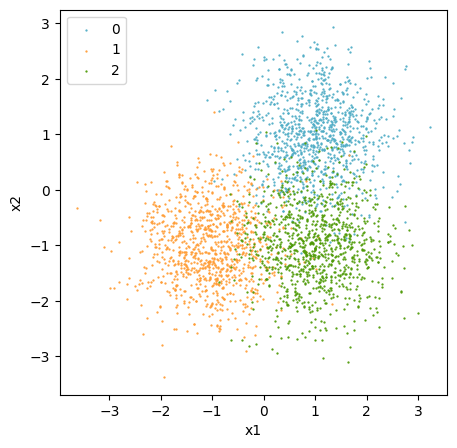

In [48]:
plot_blobs(X, labels_true)

### K-means Clustering


FORMALLY: 
each partition $S_i \subset X$ has a center point (centroid $c_i$)  
  
we would like to solve the following problem:
$$ 
    arg min_S \sum_{i=1}^K \sum_{x \in S_i} dist(x, c_i)
$$
where $c_i$ is the mean of points in $S_i$. 
Suppose to use the norm 2 distance $dist(x,c_i) = || x - c_i||^2$

<img src="kmean_steps/1.png" style="width: 300px;"/> \


<img src="kmean_steps/2.png" style="width: 300px;"/> \


<img src="kmean_steps/3.png" style="width: 300px;"/> \


<img src="kmean_steps/4.png" style="width: 300px;"/> \


<img src="kmean_steps/5.png" style="width: 300px;"/> \


<img src="kmean_steps/6.png" style="width: 300px;"/> \


<img src="kmean_steps/7.png" style="width: 300px;"/> \


<img src="kmean_steps/8.png" style="width: 300px;"/>

In [49]:
import time
from sklearn.cluster import KMeans

## Call KMeans by choosing also how to initialize, number of cluster, and number of restarts
k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)

# start counting time
t0 = time.time()

k_means.fit(X)

# end of training
t_batch = time.time() - t0

print('Required training time:', '{:.3f}'.format(t_batch), 'sec.' )

Required training time: 0.093 sec.


In [50]:
from sklearn.cluster import MiniBatchKMeans

# This variant implements KMeans by selecting mini-batches 
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size, # you can see here the batch_size kwarg
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)

# start counting time
t0 = time.time()

mbk.fit(X)

# end of training
t_mini_batch = time.time() - t0

print('Required training time:', '{:.3f}'.format(t_mini_batch), 'sec.' )

Required training time: 0.068 sec.


In [51]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

# evaluate centers for two variants
k_means_cluster_centers = k_means.cluster_centers_
mbk_means_cluster_centers = mbk.cluster_centers_

# make sure to reorder cluster labels
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk_means_cluster_centers[order]

# assign unsupervised labels based on minimum distance from cluster centers
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

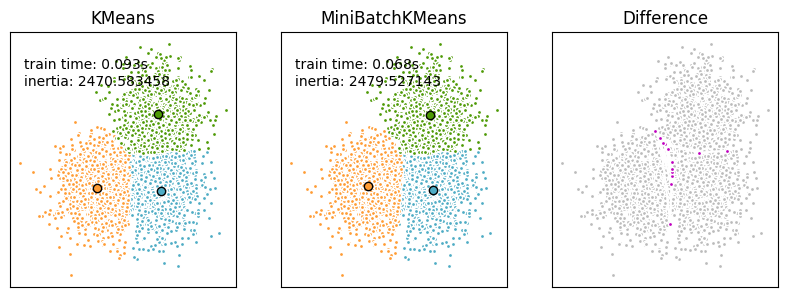

In [52]:
plot_K_means(X, 3, 
             k_means, k_means_labels, k_means_cluster_centers,
             mbk, mbk_means_labels, mbk_means_cluster_centers,
             t_batch, t_mini_batch)

### Decision surface

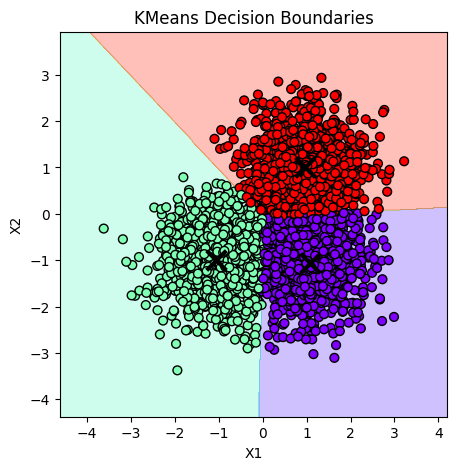

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kmeans_decision_boundaries(X, kmeans_model):
    """
    Plot the decision boundaries (contours) of a KMeans model.

    Parameters:
    - X (numpy array): Input data for clustering.
    - kmeans_model: Fitted KMeans model.
    """
    # Step size of the meshgrid
    h = 0.02

    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Get predicted labels for each point in the meshgrid
    Z = kmeans_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)

    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=kmeans_model.labels_, cmap=plt.cm.rainbow, edgecolor='k', s=40)
    
    # Plot the cluster centers
    plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='black')

    plt.title("KMeans Decision Boundaries")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

# Plot decision boundaries
plot_kmeans_decision_boundaries(X, k_means)


### How many clusters?

Suppose we do not know how many clusters should be used in the problem. How can we choose a suitable number?

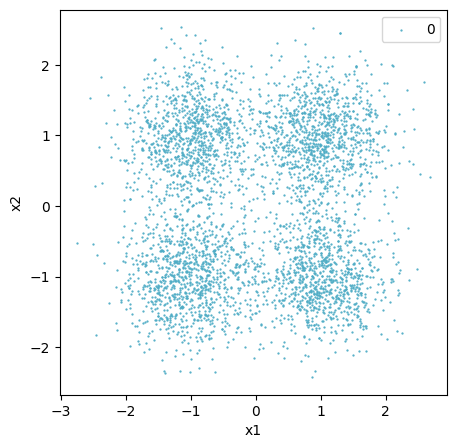

In [56]:
centers = [[1, 1], [-1, -1], [1, -1], [-1,1]]
n_clusters = len(centers)

X, _ = make_blobs(4000, 2, centers=centers, cluster_std=0.5)
gt_labels = np.zeros(X.shape[0], dtype=int)

plot_blobs(X,gt_labels)

In [57]:
from sklearn.cluster import KMeans
wcss = [] 
models, labels, centers, = [], [], []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    models.append(kmeans)
    labels.append(kmeans.predict(X))
    centers.append(kmeans.cluster_centers_)
    wcss.append(kmeans.inertia_)



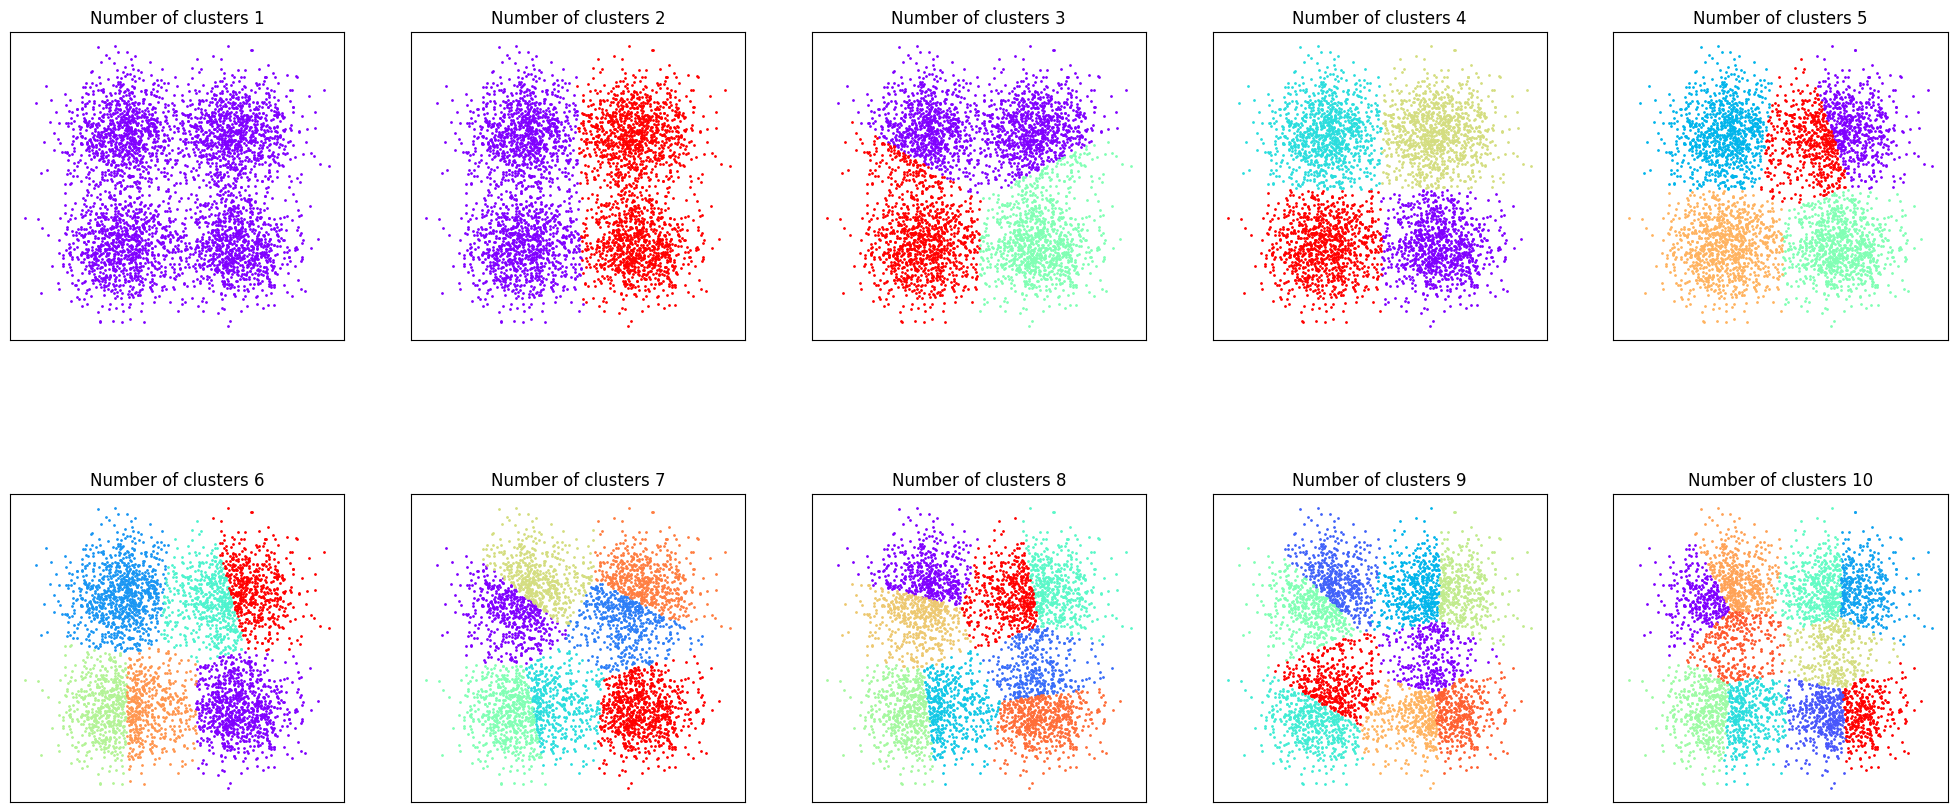

In [58]:
plot_kmeans_clusters(X, labels, centers)


### Which one should we choose?

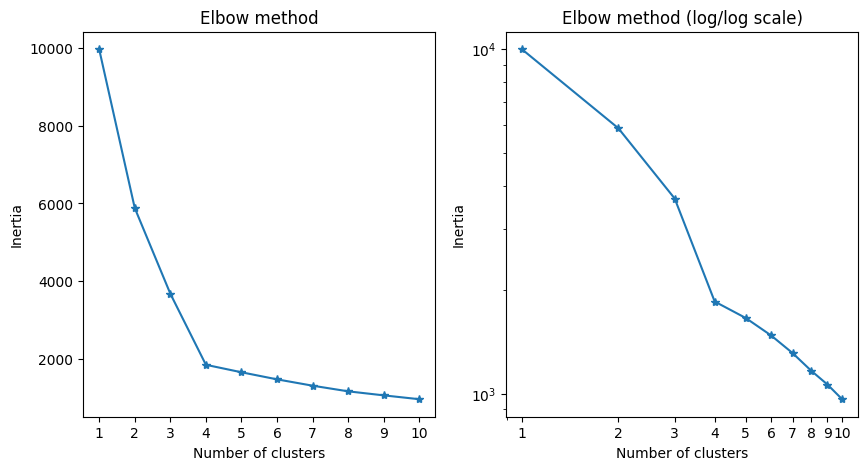

In [59]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(121)

plt.plot(range(1, 11), wcss, marker='*')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia') 

plt.xticks(range(1,11), list(range(1,11)))
plt.title('Elbow method')

fig.add_subplot(122)
plt.plot(range(1, 11), wcss, marker='*')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia') 

plt.xscale('log')
plt.yscale('log')
plt.xticks(range(1,11), list(range(1,11)))
plt.title('Elbow method (log/log scale)')

plt.show()

## Gaussian Mixture Models

In [84]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plot an ellipse for a given covariance matrix and position.

    Parameters:
        - cov: Covariance matrix.
        - pos: Position (mean) of the ellipse.
        - nstd: The radius of the ellipse in terms of standard deviations.
        - ax: Matplotlib axes on which to plot the ellipse.
        - **kwargs: Additional keyword arguments for matplotlib.patches.Ellipse.
    """
    if ax is None:
        ax = plt.gca()

    # Calculate ellipse parameters
    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])

    # Calculate ellipse angle and center
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    center = pos

    # Create and plot the ellipse
    ell = Ellipse(xy=center, width=v[0] * nstd, height=v[1] * nstd, angle=angle, **kwargs)
    ax.add_patch(ell)

    return ell

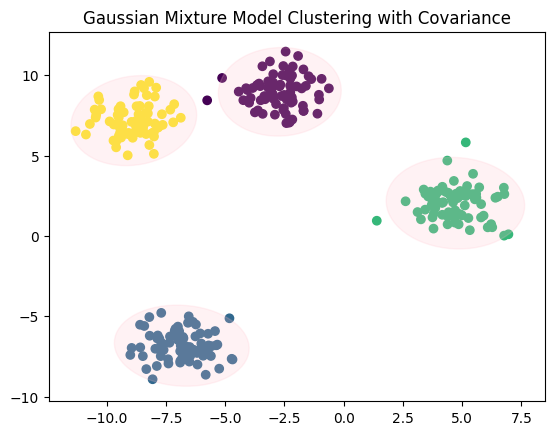

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

# Generate some synthetic data for illustration
X, y = make_blobs(n_samples=300, centers=4, random_state=42)

# Create a Gaussian Mixture Model with a specified number of components (clusters)
n_components = 4
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Fit the model to the data
gmm.fit(X)

# Predict the cluster labels for each data point
labels = gmm.predict(X)

# Plot the data points with color-coded cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')

# Plot ellipses for each Gaussian component
for i in range(n_components):
    plot_cov_ellipse(gmm.covariances_[i], gmm.means_[i], ax=plt.gca(), color='pink', alpha=0.3)

plt.title('Gaussian Mixture Model Clustering with Covariance')
plt.show()


### Solving classification problems with GMMS

In [4]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

from utils.plot_utils import estimate_GMMS

# Load the iris dataset.
iris = datasets.load_iris()

print(iris['feature_names'])

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.25)

n_classes = len(np.unique(y_train))



['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [ ]:
# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

estimate_GMMS(estimators, X_train, X_test, y_train, y_test)

# Dimensionality Reduction

### Real Dataset: Wine Dataset

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines [1].

[1] https://archive.ics.uci.edu/ml/datasets/wine

In [1]:
import pandas as pd

df_wine = pd.read_csv("../sklearn/data/wine.csv")
df_wine.head()

,type,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
df_wine.describe()

,type,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [3]:
# Separate the data into target and features
y = df_wine["type"]
X = df_wine.drop(columns=["type"])

In [4]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Initialize a PCA object and transform the data
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)

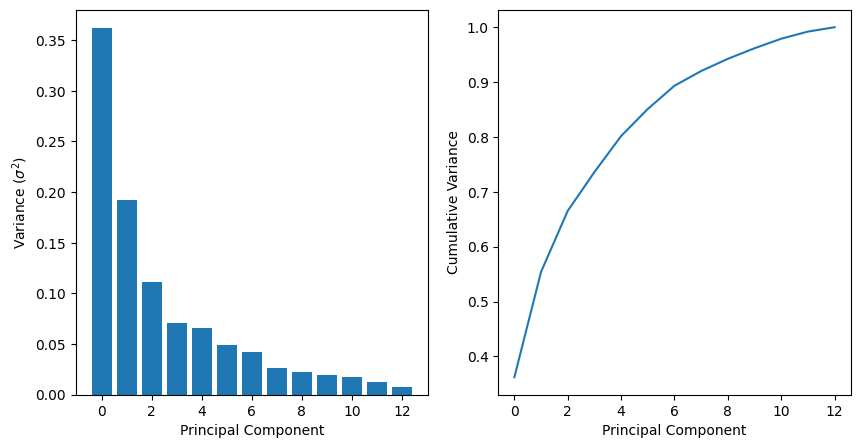

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the explained variace ratio for each component
percent_variance = pca.explained_variance_ratio_

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.bar(np.arange(len(percent_variance)), height=percent_variance)
plt.ylabel("Variance ($\sigma^2$)")
plt.xlabel("Principal Component")

fig.add_subplot(122)

sum_variance = [ np.sum(percent_variance[:i+1]) for i in range(len(percent_variance))]

plt.plot(np.arange(len(percent_variance)), sum_variance)
plt.ylabel("Cumulative Variance")
plt.xlabel("Principal Component")


plt.show()

The point of inflexion (where the line starts to bend) should indicate how many components have to be retained. In this case, the magic number is 3

### PCA (2-dimensions)

In [8]:
# Initialize a PCA object (2 components) and transform data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

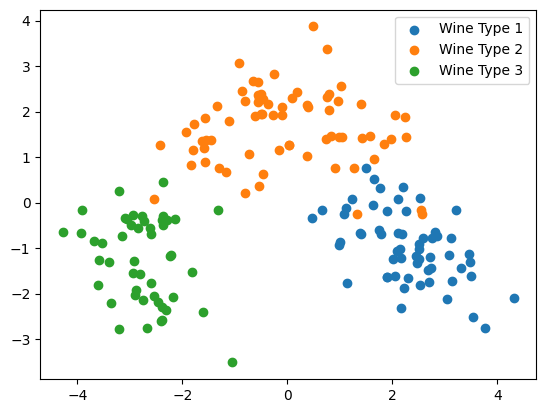

In [9]:
# Plot the data by using the utils.lib.plot_pca_clusters function
from utils.plot_utils import plot_pca_clusters
plot_pca_clusters(X_pca, y)

### PCA (3-dimensions)

In [10]:
# Initialize a PCA object (3 components) and transform data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

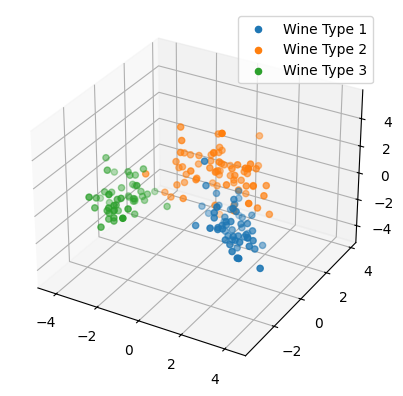

In [11]:
# Plot the data by using the utils.lib.plot_pca_clusters function
plot_pca_clusters(X_pca, y, True)